In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Model, Sequential
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Conv2DTranspose,\
                                    Reshape, ReLU, LeakyReLU,BatchNormalization, Lambda, \
                                    UpSampling2D, Softmax, Input, Dropout, AvgPool2D, Concatenate, \
                                    LocallyConnected2D, SpatialDropout2D, Activation, InputLayer, \
                                    GaussianNoise
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

In [2]:
tf.__version__

'2.0.0'

In [47]:
with np.load('/home/etheredge/Workspace/tcvae/data/gan_generated_guppies_fewer_samples.npz') as f:
    gan_images, gan_labels = f['x_train'], f['y_train'].astype('int')
# real_images = np.load("/home/etheredge/Workspace/tcvae/data/imgs_trainVAE.npy")
# real_labels = np.load("/home/etheredge/Workspace/tcvae/data/lines_trainVAE.npy")

In [48]:
images = gan_images
images_class = gan_labels
# images = real_images
# image_class = real_labels
images = images.astype('float32')
images = images / images.max().max()

In [5]:
images[0].shape

(256, 256, 3)

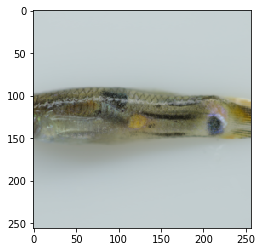

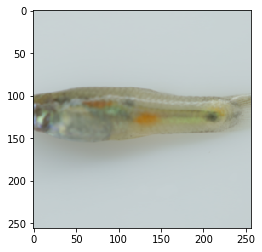

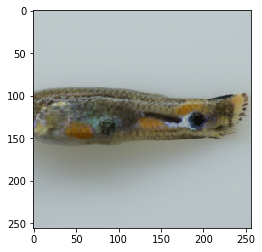

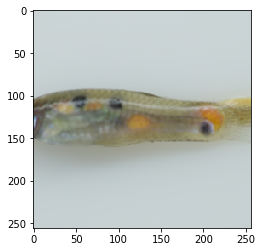

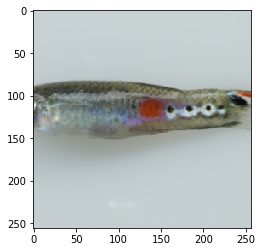

In [6]:
for i in np.random.randint(0,  len(images)-1, 5):
    plt.imshow(images[i])
    plt.show()

In [7]:
tf.keras.backend.clear_session()
gc.collect()

11733

## Network definition
1. Layers between the input, $h_1, h_2, h_3$ are sequences of a convolutional layer, batch normalization and relu. 
2. Sometimes there is a SpatialDroput layer to make the model more robust
3. The encoder part output $h_1, h_2, h_3$ that are given in input respectively to $z_1, z_2, z_3$, three normal stochastic layers
4. Then $\widetilde{z}_3$ is obtained from $z_3$ with three Dense/BN/Relu with size 1024
5. $\widetilde{z}_2$ receive in input the concatenation of $[\widetilde{z}_3, g(z_2)]$ where $g(\cdot)$ is a neural network; <br>
in my case is a single Dense layer with relu activation
5. $\widetilde{z}_1$ receive in input the concatenation of $[\widetilde{z}_2, g(z_1)]$ where $g(\cdot)$ is a neural network; <br>
in my case is a single Dense layer with relu activation
6. From $\widetilde{z}_1$ starts the effective decoder part, that increase the size until the original one. Differently from the original paper, i've used UpSampling2D/Conv2D instead of Transpose convolution because produce less artifacts  <br><br>
Note: Since the learnable params of batch norm gives every training NaN values into it i've virtually removed setting trainable=False into every BatchNorm layer; honestly i don't understood exactly the NaN reason, maybe the stochasticity of this neural network 

In [8]:
# q_mu, q_sigma, p_mu, p_sigma):
    
#     r = q_mu - p_mu
#     kl = np.sum(np.log(p_sigma) - np.log(q_sigma) - .5 * (1. - (q_sigma**2 + r**2) / p_sigma**2), axis=-1)

In [9]:
#     def add_kl_divergence(self, mu1, sigma1, mu2, sigma2):
#             logsigma1, logsigma2 = tf.math.log(sigma1), tf.math.log(sigma2)
#             mu_diff = mu1 - mu2
#             kl = self.coef_kl * \
#                 tf.reduce_sum(logsigma1 - logsigma2 - 1. + (sigma2 + tf.square(mu_diff)) / sigma1, axis=1)
#             kl = tf.reduce_mean(kl)
#             self.add_loss(kl)
#             self.add_metric(kl, 'mean', 'kl_divergence')

In [10]:
class SaltAndPepper(tf.keras.layers.Layer):

    def __init__(self, ratio=0.9, **kwargs):
        super(SaltAndPepper, self).__init__(**kwargs)
        self.supports_masking = True
        self.ratio = ratio

    def call(self, inputs, training=None):
        def noised():
            shp = K.shape(inputs)[1:]
            mask_select = K.random_binomial(shape=shp, p=self.ratio)
            mask_noise = K.random_binomial(shape=shp, p=0.1) # salt and pepper have the same chance
            out = (inputs * (mask_select)) + mask_noise
            return out

        return K.in_train_phase(noised(), inputs, training=training)

    def get_config(self):
        config = {'ratio': self.ratio}
        base_config = super(SaltAndPepper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [11]:
class NormalVariational(tf.keras.layers.Layer):
    
    def __init__(self, size, mu_prior=0., sigma_prior=1., add_kl=True, coef_kl = 1.0, add_mmd=False, lambda_mmd=1.0, kernel_f=None, name=None, show_posterior=False):
        super().__init__(name=name)
        self.mu_layer = tf.keras.layers.Dense(size)
        self.sigma_layer = tf.keras.layers.Dense(size)
        self.add_kl = add_kl
        self.mu_prior = tf.constant(mu_prior, dtype=tf.float32, shape=(size,))
        self.sigma_prior = tf.constant(sigma_prior, dtype=tf.float32, shape=(size,))
        self.show_posterior = show_posterior
        self.coef_kl = tf.Variable(coef_kl, trainable=False, name='coef_kl')
        self.add_mmd = add_mmd
        if kernel_f is None:
            self.kernel_f = self._rbf
        else:
            self.kernel_f = kernel_f
        self.lambda_mmd = lambda_mmd
            
    def _rbf(self, x, y):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
        tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
        return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))
    
    def _linear(self, x,y):
        return tf.reduce_sum(tf.multiply(x,y))
            
    def add_kl_divergence(self, q_mu, q_sigma, p_mu, p_sigma):
        r = q_mu - p_mu
        kl = tf.reduce_mean(self.coef_kl * tf.reduce_sum(tf.math.log(p_sigma) - tf.math.log(q_sigma) - .5 * (1. - (q_sigma**2 + r**2) / p_sigma**2), axis=1))
        self.add_loss(kl)
        self.add_metric(kl, 'mean', 'kl_divergence')

    def call(self, inputs):
        mu = self.mu_layer(inputs)
        log_sigma =  self.sigma_layer(inputs)
        sigma_square = tf.exp(log_sigma)
        if self.add_kl:
            self.add_kl_divergence(mu, sigma_square, self.mu_prior, self.sigma_prior)
            
        if self.show_posterior:
            self.add_metric(mu, 'mean', 'mu_posteror')
            self.add_metric(sigma_square, 'mean', 'sigma2_posterior')
            
        z = mu + sigma_square * tf.random.normal(tf.shape(sigma_square))
        if self.add_mmd:
            z_prior = tfp.distributions.MultivariateNormalDiag(self.mu_prior, self.sigma_prior).sample(tf.shape(z)[0])
            print(z_prior)
            print(z)
            k_prior = self.kernel_f(z_prior, z_prior)
            k_post = self.kernel_f(z, z)
            k_prior_post = self.kernel_f(z_prior, z)
            mmd = tf.reduce_mean(k_prior) + tf.reduce_mean(k_post) - 2 * tf.reduce_mean(k_prior_post)
            mmd = tf.multiply(self.lambda_mmd,  mmd, name='mmd')
            self.add_loss(mmd)
            self.add_metric(mmd, 'mean', 'mmd')

        return z


In [12]:
def make_encoder(latent_size):
    
    inputs = Input((256,256,3))
    with tf.name_scope('noise'):
        noise_layers = Sequential([
            SaltAndPepper(),
            GaussianNoise(0.1)
            ], name='noise')
        noisy_inputs = noise_layers(inputs)

    with tf.name_scope('h_1'):
        h_1_layers = Sequential([ 
            Input((256, 256, 3)),
            Conv2D(64, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(64, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_1')
        h_1 = h_1_layers(noisy_inputs)
        h_1_flatten = Flatten()(h_1)

    with tf.name_scope('h_2'):
        h_2_layers = Sequential([ 
            Conv2D(128, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(128, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(256, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_2')
        h_2 = h_2_layers(h_1)
        h_2_flatten = Flatten()(h_2)

    with tf.name_scope('h_3'):
        h_3_layers = Sequential([ 
            Conv2D(256, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(512, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(512, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_3')
        h_3 = h_3_layers(h_2)
        h_3_flatten = Flatten()(h_3)

    with tf.name_scope('h_4'):
        h_4_layers = Sequential([ 
            Dense(1024, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Dense(1024, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_4')
        h_4 = h_4_layers(h_3)
        h_4_flatten = Flatten()(h_4)

    return Model(inputs, [h_1_flatten, h_2_flatten, h_3_flatten, h_4_flatten], name='encoder')

In [13]:
def make_decoder(latent_dim1, latent_dim2, latent_dim3, latent_dim4):
    z_1_input, z_2_input, z_3_input, z_4_input = Input((latent_dim1,), name='z_1'), Input((latent_dim2,), name='z_2'), Input((latent_dim3,), name='z_3'), Input((latent_dim4,), name='z_4')
    
    with tf.name_scope('z_tilde_4'):
        z_4 = z_4_input
        z_tilde_4_layers = Sequential([
            Dense(1024, kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Dense(1024, kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Dense(16*16*512, kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Reshape((16,16,512))], name='z_tilde_4')
        z_tilde_4 = z_tilde_4_layers(z_4)

    with tf.name_scope('z_tilde_3'):
        z_3 = Dense(16*16*512, kernel_regularizer=l2(2.5e-5))(z_3_input)
        z_3 = BatchNormalization()(z_3)
        z_3 = ReLU()(z_3)
        z_3 = Reshape((16,16,512))(z_3)
        z_tilde_3_layers = Sequential([
            Conv2DTranspose(512, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(256, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(256, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU()], name='z_tilde_3')
        input_z_tilde_3 = Concatenate()([z_tilde_4, z_3])
        z_tilde_3 = z_tilde_3_layers(input_z_tilde_3)
        
    with tf.name_scope('z_tilde_2'):
        z_2 = Dense(32*32*256, kernel_regularizer=l2(2.5e-5))(z_2_input)
        z_2 = BatchNormalization()(z_2)
        z_2 = ReLU()(z_2)
        z_2 = Reshape((32,32,256))(z_2)
        z_tilde_2_layers = Sequential([
            Conv2DTranspose(128, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(128, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(64, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU()], name='z_tilde_2')
        input_z_tilde_2 = Concatenate()([z_tilde_3, z_2])
        z_tilde_2 =  z_tilde_2_layers(input_z_tilde_2)
    
    with tf.name_scope('z_tilde_1'):
        z_1 = Dense(128*128*64, kernel_regularizer=l2(2.5e-5))(z_1_input)
        z_1 = BatchNormalization()(z_1)
        z_1 = ReLU()(z_1)
        z_1 = Reshape((128,128,64))(z_1)
        z_tilde_1_layers = Sequential([
            Conv2DTranspose(128, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            Conv2DTranspose(3, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            Activation('sigmoid')], name='z_tilde_1')
        input_z_tilde_1 = Concatenate()([z_tilde_2, z_1])
        decoder =  z_tilde_1_layers(input_z_tilde_1)

    return Model([z_1_input, z_2_input, z_3_input, z_4_input], decoder, name='decoder')

In [14]:
def make_vlae(latent_size):
    with tf.name_scope('encoder'):
        encoder = make_encoder(latent_size)
    with tf.name_scope('decoder'):
        decoder = make_decoder(latent_size, latent_size, latent_size, latent_size)
    inputs = Input((256,256,3))
    h_1, h_2, h_3, h_4 = encoder(inputs)
    z_1 = NormalVariational(latent_size, add_kl=True, coef_kl=1., add_mmd=False, lambda_mmd=.5, name='z_1_latent')(h_1)
    z_2 = NormalVariational(latent_size, add_kl=True, coef_kl=1., add_mmd=False, lambda_mmd=.5, name='z_2_latent')(h_2)
    z_3 = NormalVariational(latent_size, add_kl=True, coef_kl=1., add_mmd=False, lambda_mmd=.5, name='z_3_latent')(h_3)
    z_4 = NormalVariational(latent_size, add_kl=True, coef_kl=1., add_mmd=False, lambda_mmd=.5, name='z_4_latent')(h_4)
    
    decoded = decoder([z_1, z_2, z_3, z_4])
    vlae = Model(inputs, decoded, name='vlae')
    return vlae

In [50]:
def frange_cycle_linear(n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
    L = np.ones(n_iter) * stop
    period = n_iter/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):
        v, i = start, 0
        while v <= stop and (int(i+c*period) < n_iter):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L 

In [51]:
# class KLWarmUp(tf.keras.callbacks.Callback):
    
#     def __init__(self, vlae, start_epoch = 1, max_value = 1.0, delta = 0.05):
#         self.start_epoch = start_epoch
#         self.max_value = 1.0
#         self.delta = delta 
#         self.epoch = 0
#         self.vlae = vlae
        
        
#     def on_epoch_end(self, *args, **kwargs):
#         self.epoch += 1
#         if self.start_epoch <= self.epoch:
#             coefs = [self.vlae.get_layer(f'z_{i+1}_latent').coef_kl for i in range(3)]
#             for coef in coefs:
#                 if coef <= self.max_value:
#                     coef.assign_add(self.delta)

In [52]:
class KLWarmUp(tf.keras.callbacks.Callback):
    
    def __init__(self, vlae, n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
        self.frange = frange_cycle_linear(n_iter, start=start, stop=stop,  n_cycle=n_cycle, ratio=ratio)
        self.vlae = vlae
        self.epoch = 0
        
        
    def on_epoch_end(self, *args, **kwargs):
        new_coef = self.frange[self.epoch]
        self.epoch += 1
        coefs = [self.vlae.get_layer(f'z_{i+1}_latent').coef_kl for i in range(3)]
        for coef in coefs:
            coef.assign(new_coef)
    
    @staticmethod
    def frange_cycle_linear(n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
        L = np.ones(n_iter) * stop
        period = n_iter/n_cycle
        step = (stop-start)/(period*ratio) # linear schedule

        for c in range(n_cycle):
            v, i = start, 0
            while v <= stop and (int(i+c*period) < n_iter):
                L[int(i+c*period)] = v
                v += step
                i += 1
        return L 

In [18]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 25836), started 1 day, 15:00:28 ago. (Use '!kill 25836' to kill it.)

In [23]:
latent_size = 10
vlae = make_vlae(latent_size)

In [53]:
epochs = 500
tb = TensorBoard(write_images=False, write_graph=True, histogram_freq=25)
es = EarlyStopping(monitor='loss', min_delta=0.001, patience=15)
klwarmup = KLWarmUp(vlae, epochs)
lr_epochs = 10 ** np.linspace(-5, -8, epochs)
lrsched = LearningRateScheduler(lambda i: lr_epochs[i])

In [25]:
vlae.summary()

Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 984064), (No 9918848     input_6[0][0]                    
__________________________________________________________________________________________________
z_1_latent (NormalVariational)  (None, 10)           19681301    encoder[1][0]                    
__________________________________________________________________________________________________
z_2_latent (NormalVariational)  (None, 10)           4014101     encoder[1][1]                    
_______________________________________________________________________________________________

In [26]:
def loss(x,xhat):
    return  0.5 * tf.losses.mean_squared_error(Flatten()(x), Flatten()(xhat)) * np.prod(images[0].shape)

vlae.compile(tf.keras.optimizers.Adam(), loss)

In [54]:
vlae.fit(images, images, batch_size=10, epochs=epochs, callbacks=[tb, lrsched, klwarmup])

Train on 13000 samples
Epoch 1/500
13000/13000 [==============================] - 302s 23ms/sample - loss: 218.2364 - kl_divergence: 1.3167
Epoch 2/500
13000/13000 [==============================] - 294s 23ms/sample - loss: 103.3661 - kl_divergence: 0.8319
Epoch 3/500
13000/13000 [==============================] - 296s 23ms/sample - loss: 98.0193 - kl_divergence: 0.6945
Epoch 4/500
13000/13000 [==============================] - 295s 23ms/sample - loss: 96.3573 - kl_divergence: 0.6035
Epoch 5/500
13000/13000 [==============================] - 297s 23ms/sample - loss: 96.7742 - kl_divergence: 0.5172
Epoch 6/500
13000/13000 [==============================] - 297s 23ms/sample - loss: 97.3956 - kl_divergence: 0.4705
Epoch 7/500
13000/13000 [==============================] - 298s 23ms/sample - loss: 99.7190 - kl_divergence: 0.5142
Epoch 8/500
13000/13000 [==============================] - 298s 23ms/sample - loss: 107.2711 - kl_divergence: 0.4705
Epoch 9/500
13000/13000 [=====================

InvalidArgumentError: Nan in summary histogram for: conv2d_8/kernel_0 [Op:WriteHistogramSummary] name: conv2d_8/kernel_0/

In [28]:
# tf.saved_model.save(vlae, 'vlae_real')

# Generation
In order to generate is sufficient sample from the prior (in my case a N(0,1)) three times because there are three latent variable in this model <br>
Then feed into the VLAE-decoder this three random sampled values 

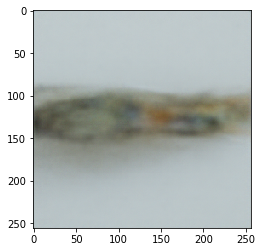

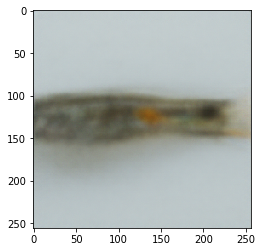

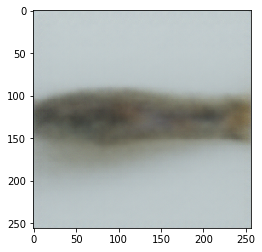

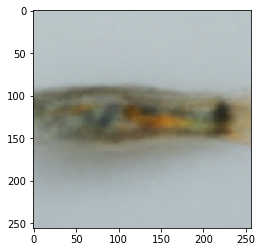

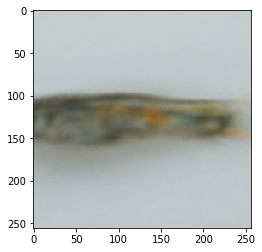

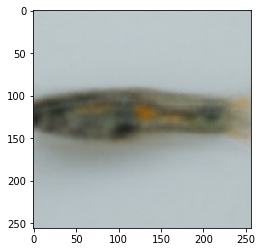

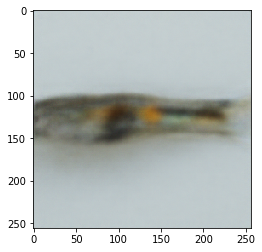

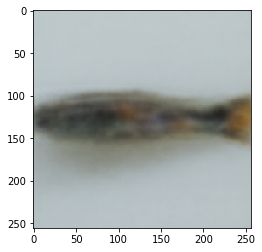

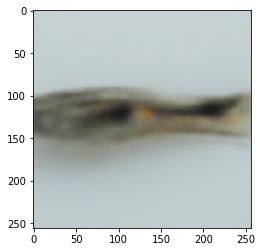

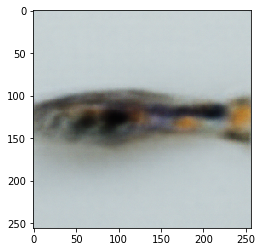

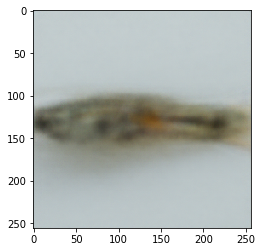

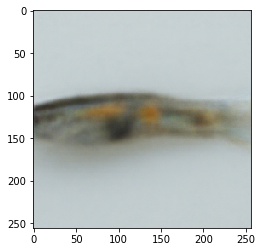

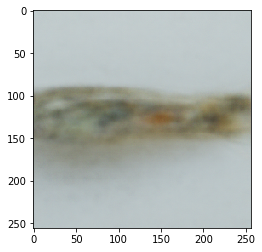

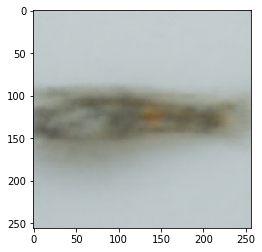

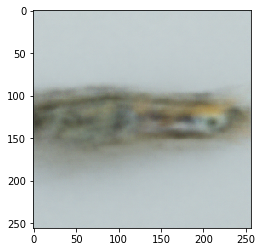

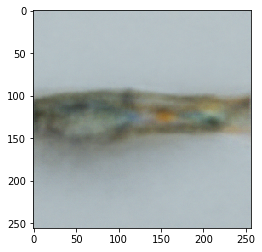

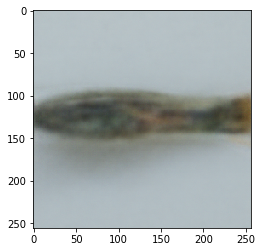

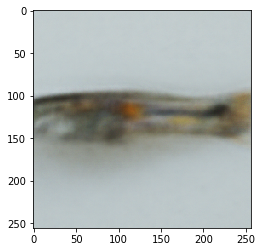

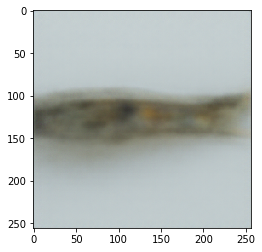

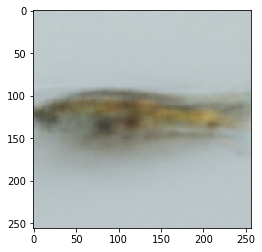

In [29]:
sample = [np.random.multivariate_normal([0] * latent_size, np.diag([1] * latent_size), 20)] * 4
generated = vlae.get_layer('decoder').predict(sample)
generated = generated.reshape((20, 256, 256,3))

for i in range(20):
    img = generated[i]
    plt.imshow(img)
    plt.show()

In [47]:
real_images = np.load("/home/etheredge/Workspace/tcvae/data/imgs_trainVAE.npy")
real_labels = np.load("/home/etheredge/Workspace/tcvae/data/lines_trainVAE.npy")
images = real_images

In [48]:
# real_images = np.load('/mnt/jordanlab/People/ietheredge/Guppies_Final/pattern_space/data/brooks_imgs_256.npy')
# attrs = np.load('/mnt/jordanlab/People/ietheredge/Guppies_Final/pattern_space/data/brooks_attrs.npy')
# images = real_images

In [49]:
images[0].shape

(256, 256, 3)

In [30]:
h_0 = []
h_1 = []
h_2 = []
h_3 = []
for image in images:
    x = vlae.get_layer('encoder').predict(np.expand_dims(image, axis=0));
    h_0.append(vlae.get_layer('z_1_latent')(x[0]))
    h_1.append(vlae.get_layer('z_2_latent')(x[1]))
    h_2.append(vlae.get_layer('z_3_latent')(x[2]))
    h_3.append(vlae.get_layer('z_4_latent')(x[3]))

h_3 = np.array(h_3)
h_3 = h_3.reshape(images.shape[0],latent_size)

h_2 = np.array(h_2)
h_2 = h_2.reshape(images.shape[0],latent_size)

h_1 = np.array(h_1)
h_1 = h_1.reshape(images.shape[0],latent_size)

h_0 = np.array(h_0)
h_0 = h_0.reshape(images.shape[0],latent_size)

In [31]:
import umap
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import itertools

In [32]:
def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z


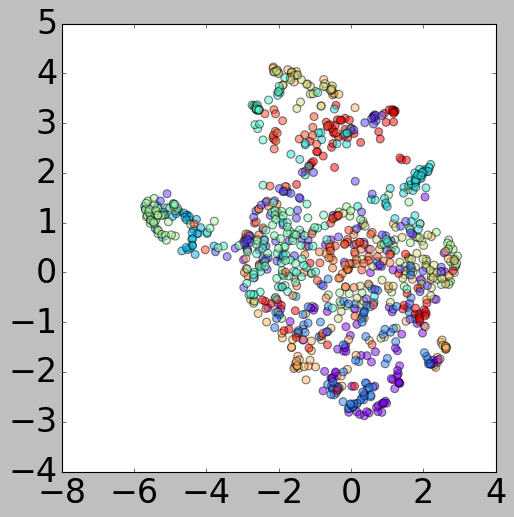

In [45]:
L = real_labels
# Z = np.concatenate([h_0, h_1, h_2, h_3],axis=1)
Z = h_0
reducer = umap.UMAP(random_state=2, n_neighbors=30)
embedding = reducer.fit_transform(Z)
# embedding = TSNE(n_components=2, init='pca').fit_transform(Z)
Y = np.array(L)
fig, ax = plt.subplots(figsize=(7,7));
# ax = plt.subplot(1,1,1)
# scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=Y, cmap='jet', s=50)
classnames, indices = np.unique(Y, return_inverse=True)
N = len(classnames)

cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=50)

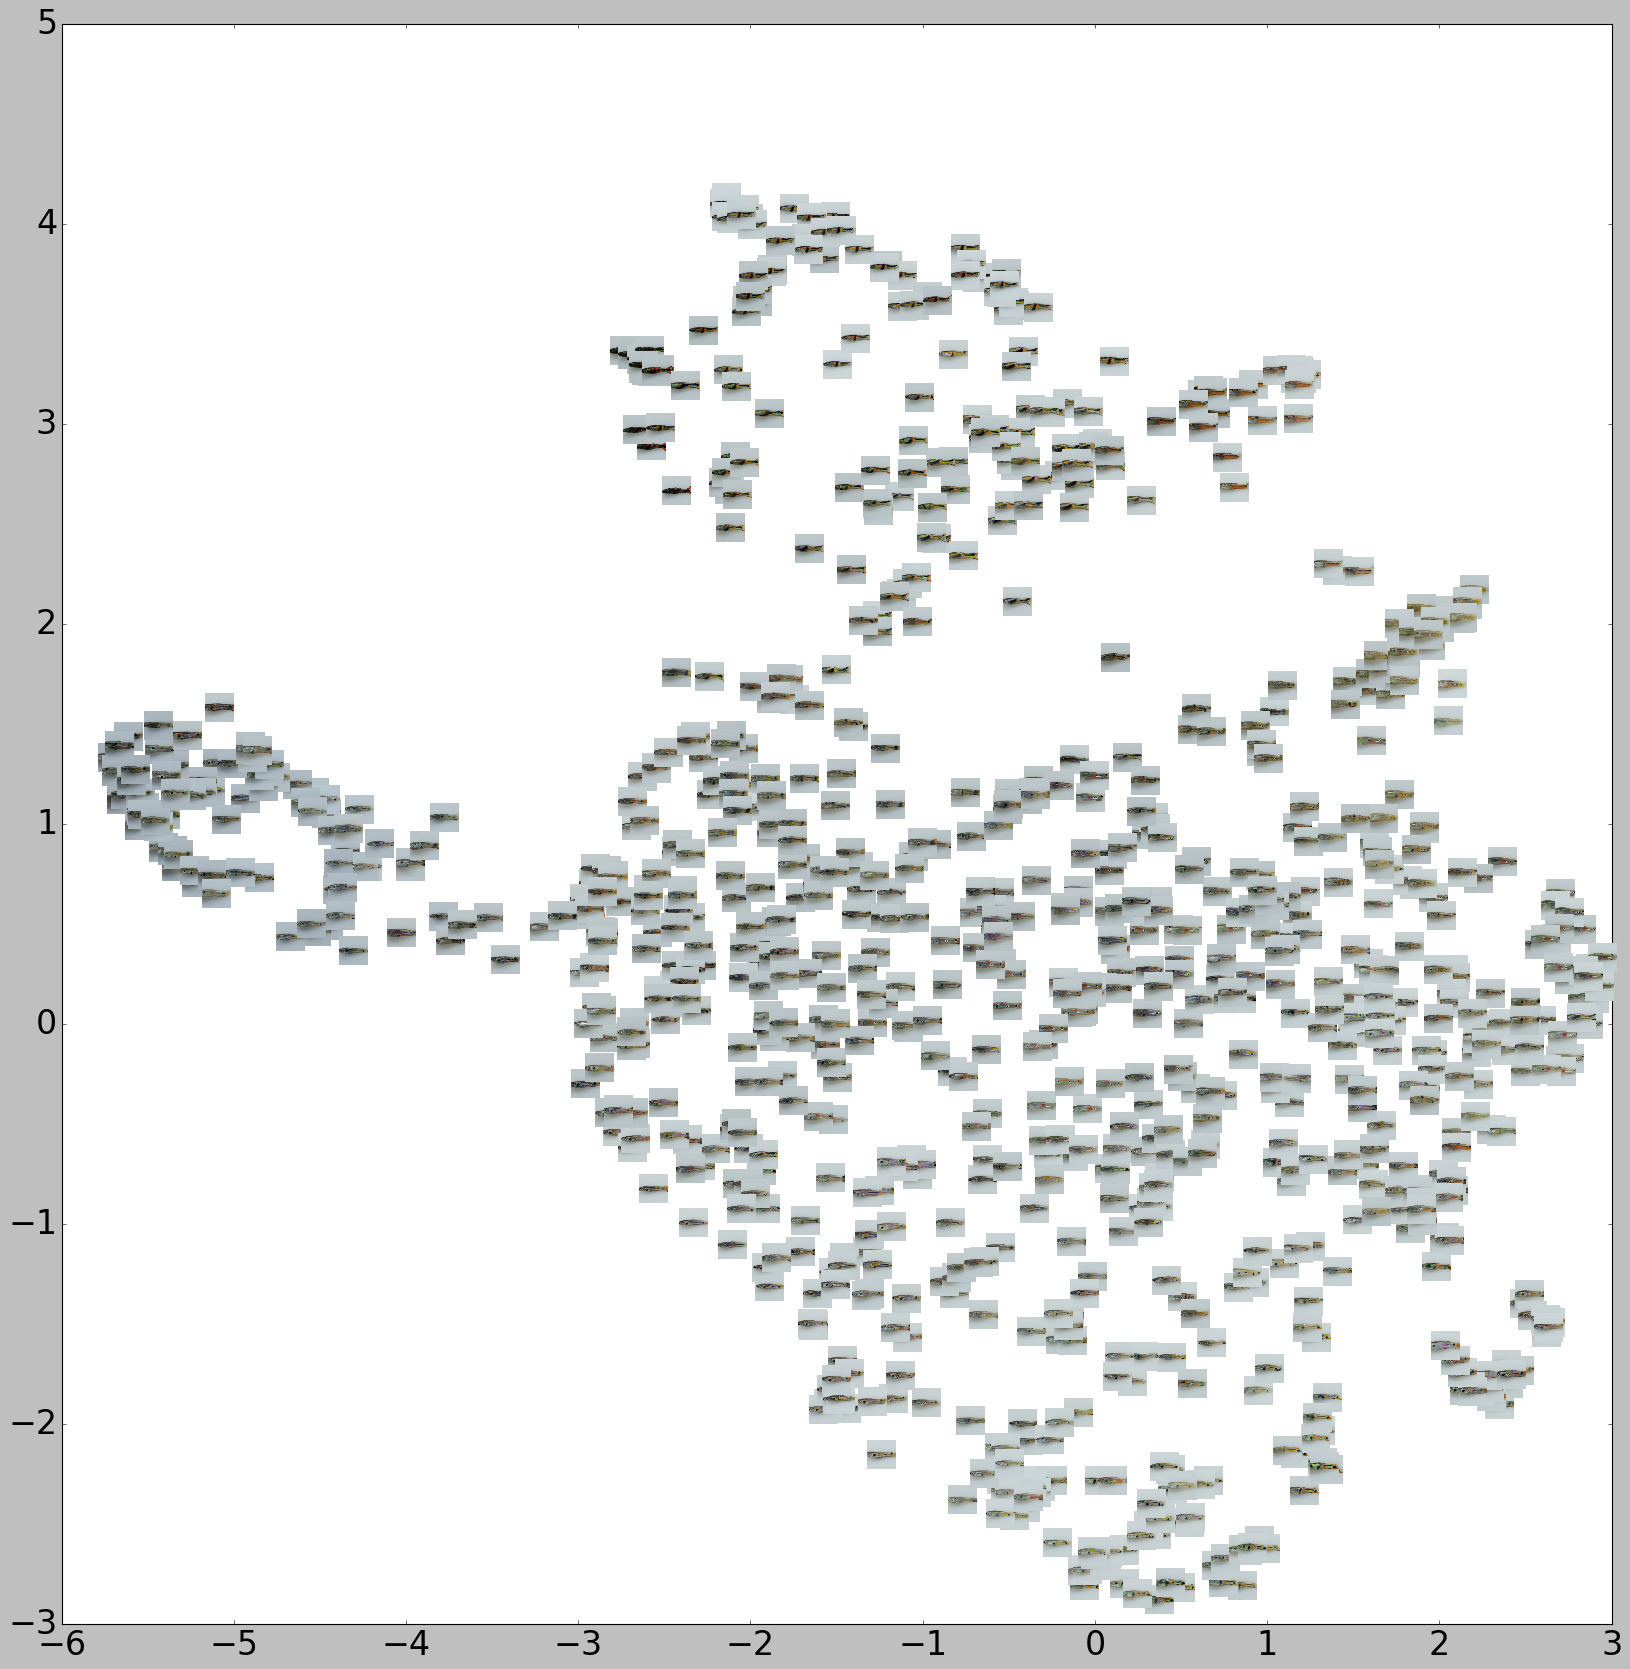

In [46]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.style.use('classic')
plt.rcParams.update({'font.size': 30})
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca();
    try:
        image = plt.imread(image);
    except TypeError:
        # Likely already an array...
        pass
    x, y = np.atleast_1d(x, y);
    artists = [];
    for i, (x0, y0) in enumerate(zip(x, y)):
        im = OffsetImage(image[i], zoom=zoom);
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False);
        artists.append(ax.add_artist(ab));
    ax.update_datalim(np.column_stack([x, y]));
    ax.autoscale();
    ax.grid(False);
    return artists
fig, ax = plt.subplots(figsize=(25,25));
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.1, ax=ax);

/home/etheredge/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


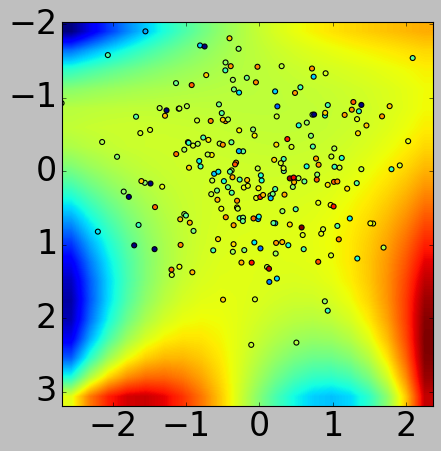

In [431]:
L = attrs[:,4]
# Z = np.concatenate([h_0, h_1, h_2, h_3],axis=1)
Z = h_0
# Z = attrs[:,2:]
# reducer = umap.UMAP(random_state=2)
reducer = PCA(n_components=2)
embedding = reducer.fit_transform(Z)
x = embedding[:, 0]
y = embedding[:, 1]
z = L
m = polyfit2d(x, y, z)
nx, ny = 20, 20
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), nx), 
                     np.linspace(y.min(), y.max(), ny))
zz = polyval2d(xx, yy, m)

plt.scatter(x, y, c=z)
plt.imshow(zz, extent=(x.min(), y.max(), x.max(), y.min()))

plt.show()

# Future improvements
* Use the label as additional information to improve the recostruction